In [1]:
# importing required libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud
from nltk.corpus import  stopwords
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import  SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix,
classification_report,f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
# reading the data in csv file
data = pd.read_csv('messages.csv')
data

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [5]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [6]:
data['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

In [7]:
print('Percentage of spam emails(%): ', round(data['label'].value_counts()[1]/data.shape[0],2)*100)
print('Percentage of ham emails(%): ', round(data['label'].value_counts()[0]/data.shape[0],2)*100)

Percentage of spam emails(%):  17.0
Percentage of ham emails(%):  83.0


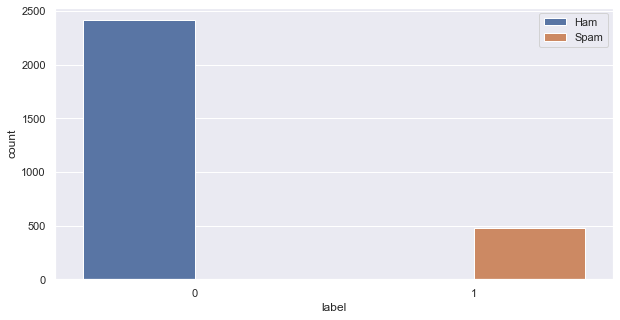

In [8]:
plt.figure(figsize = (10,5))
sb.countplot(x = 'label', data = data, hue = 'label')
plt.legend(['Ham','Spam'])
plt.show()

In [9]:
data.fillna('', inplace = True)

In [10]:
# merging 'subject' and 'message' column into single column 'message'
data['message'] = data['subject']+ ' ' + data['message']

In [11]:
#droping 'subject' column
data.drop('subject',1,inplace = True)

In [12]:
data

,message,label
0,job posting - apple-iss research center conten...,0
1,"lang classification grimes , joseph e . and b...",0
2,query : letter frequencies for text identifica...,0
3,risk a colleague and i are researching the dif...,0
4,request book information earlier this morning ...,0
...,...,...
2888,love your profile - ysuolvpv hello thanks for ...,1
2889,you have been asked to join kiddin the list ow...,1
2890,anglicization of composers ' names judging fro...,0
2891,"re : 6 . 797 , comparative method : n - ary co...",0


In [13]:
# creating column 'length' to extract string length of each document
data['length'] = data['message'].str.len()

In [14]:
data

,message,label,length
0,job posting - apple-iss research center conten...,0,2896
1,"lang classification grimes , joseph e . and b...",0,1801
2,query : letter frequencies for text identifica...,0,1486
3,risk a colleague and i are researching the dif...,0,329
4,request book information earlier this morning ...,0,1071
...,...,...,...
2888,love your profile - ysuolvpv hello thanks for ...,1,291
2889,you have been asked to join kiddin the list ow...,1,2198
2890,anglicization of composers ' names judging fro...,0,1074
2891,"re : 6 . 797 , comparative method : n - ary co...",0,3004


In [15]:
# defining function 'pre_process' to clean and pre-process the textual data
def pre_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation.replace('$','').replace('@',''))) # removing all punctuations except for '$' and '@'
    word_list = []

    for word in text.split():
            if any(char.isalpha() for char in word) and any(char.isdigit() for char in word): # discarding string containing both digit and alphabet
                word_list.append('')
            elif word =='$':  # to identify the '$' sign to replace it with 'money'
                word_list.append('money')
            elif word == 'http': # to identify the 'http' to replace it with 'link'
                word_list.append('link')
            elif word.isdigit() and str(len(word)) in  ['9','10', '11', '12']: # to identify 9, 10, 11 or 12 digit number to replace it with 'call'
                word_list.append('call')
            elif word.isdigit(): # to identify other digits and discarding them
                word_list.append('')
            else:
                word_list.append(word)

    if '@' in word_list: # to identify the '@' sign within the given regular expression to replace it with 'email'
        text=re.sub(r'\S+\s@\s\S+\s\S+','email',' '.join(word_list))
    else:
        text= ' '.join(word_list)
    words = [WordNetLemmatizer().lemmatize(word) for word in text.split() if word.lower()
             not in stopwords.words('english') and len(word)>3] # list comprehension to lemmatize and append those words that are not in the stop words and whose length are greater than 3

    return ' '.join(words)

In [16]:
%%time
# pre-processing each document in the corpus
cleaned_message = data['message'].apply(pre_process) 

Wall time: 4min 13s


In [17]:
# creating data frame of cleaned or pre-processed textual data
cleaned_data = pd.DataFrame(pd.concat([cleaned_message, cleaned_message.str.len(), data.label],1))
cleaned_data.columns = ['message','length','label']

In [18]:
cleaned_data['message']

0       posting appleiss research center content lengt...
1       lang classification grime joseph barbara grime...
2       query letter frequency text identification pos...
3       risk colleague researching differing degree ri...
4       request book information earlier morning phone...
                              ...                        
2888    love profile ysuolvpv hello thanks stopping ta...
2889    asked join kiddin list owner kiddin invited jo...
2890    anglicization composer name judging return pos...
2891    comparative method comparison gotcha separate ...
2892    american english australia hello working thesi...
Name: message, Length: 2893, dtype: object

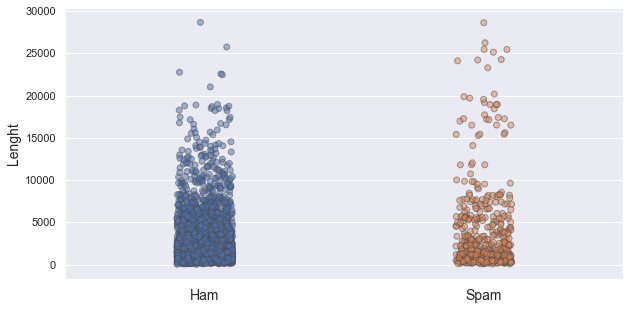

In [19]:
plt.figure(figsize = (10,5))
ax = sb.stripplot(x = 'label', y = 'length', data = data, alpha = 0.5 ,linewidth = 1, size = 6)
ax.set_xticklabels(['Ham','Spam'], fontsize = 15
                  )
ax.set_xticklabels(['Ham','Spam'], fontsize = 14)
plt.xlabel('')
plt.ylabel('Lenght',fontsize = 14)
plt.show()

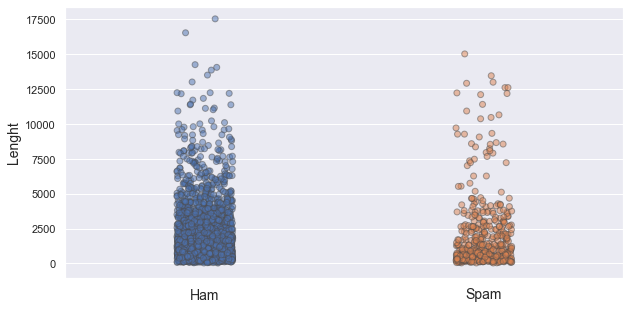

In [20]:
plt.figure(figsize = (10,5))
ax = sb.stripplot(x = 'label', y = 'length', data = cleaned_data, alpha = 0.5 ,linewidth = 1, size = 6)
ax.set_xticklabels(['Ham','Spam'], fontsize = 15
                  )
ax.set_xticklabels(['Ham','Spam'], fontsize = 14)
plt.xlabel('')
plt.ylabel('Lenght',fontsize = 14)
plt.show()

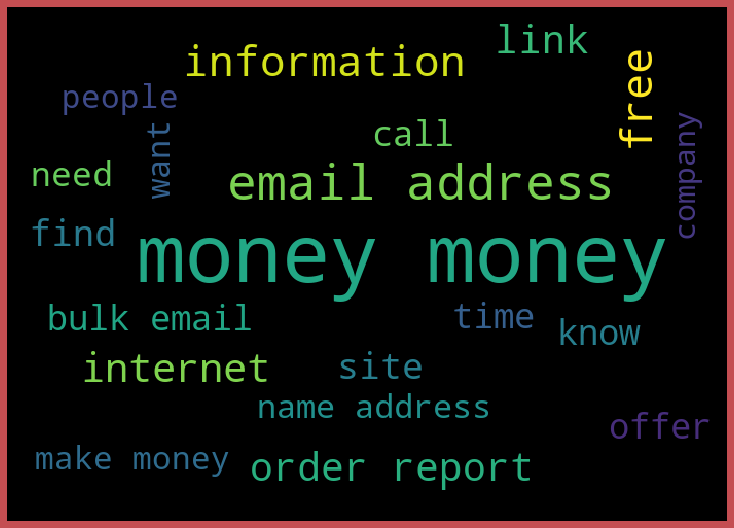

In [21]:
# visualizing most frequent words in spam mails
spams = cleaned_data['message'][cleaned_data['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

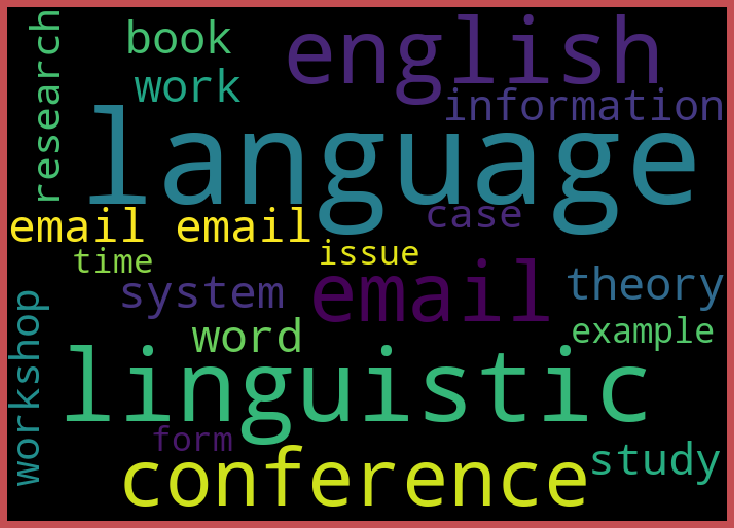

In [22]:
# visualizing most frequent words in ham mails
spams = cleaned_data['message'][cleaned_data['label']==0]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [23]:
# train-test split
x_train, x_test, y_train, y_test  = train_test_split(cleaned_data['message'], cleaned_data['label'],
                                                    stratify = cleaned_data['label'],
                 
                                                     test_size = 0.3,
                                                    random_state = 0)

In [24]:
# applying TF-IDF vectorizer by fitting it to the training set and then transforming both training and test set
tfidf = TfidfVectorizer(analyzer = 'word')
tfidf.fit(x_train)
x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test)

In [25]:
x_train.shape, y_train.shape

((2025, 40072), (2025,))

In [27]:
# using SMOTE for treating data imbalance
smote = SMOTE(sampling_strategy = 'minority', random_state = 0)
x_train, y_train = smote.fit_resample(x_train,y_train)

In [28]:
# here we have balanced our target variable
y_train.value_counts()

1    1688
0    1688
Name: label, dtype: int64

model: SVC(probability=True)
CV score:0.9907392523899479
score_std: 0.01779000977971621
----------
model: MultinomialNB()
CV score:0.9897585397894524
score_std: 0.004673081583426027
----------


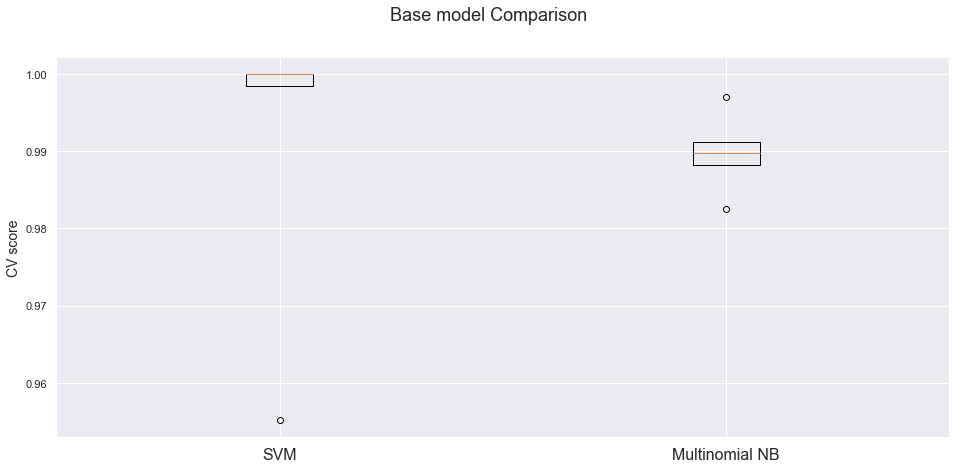

In [29]:
# initializing each model
mnb = MultinomialNB()
svm = SVC(probability = True)


models = [svm, mnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = 5 , scoring = 'f1', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 18)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['SVM','Multinomial NB'],
                  fontsize = 16)

plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(16,7)
plt.show() 

In [30]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    
    print('Model:',model,'\n')
    print('accuracy:',round(accuracy_score(y_train, y_pred)*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_train,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


Model: SVC(probability=True) 

accuracy: 100.0 % 

f1_score: 100.0 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1688
           1       1.00      1.00      1.00      1688

    accuracy                           1.00      3376
   macro avg       1.00      1.00      1.00      3376
weighted avg       1.00      1.00      1.00      3376

------------------------------------------------------------------------------


Model: MultinomialNB() 

accuracy: 99.53 % 

f1_score: 99.53 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1688
           1       0.99      1.00      1.00      1688

    accuracy                           1.00      3376
   macro avg       1.00      1.00      1.00      3376
weighted avg       1.00      1.00      1.00      3376

-------------------------------------------------

In [31]:
print('*******TEST RESULTS********')
print('\n')

for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    
    print('Model:',model,'\n')
    print('accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred)*100,2),'%','\n')
    print('roc_auc_score:', round(roc_auc_score(y_test,y_pred_proba)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: SVC(probability=True) 

accuracy: 98.27 % 

f1_score: 94.51 % 

roc_auc_score: 99.96 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.90      0.95       144

    accuracy                           0.98       868
   macro avg       0.99      0.95      0.97       868
weighted avg       0.98      0.98      0.98       868

------------------------------------------------------------------------------


Model: MultinomialNB() 

accuracy: 99.19 % 

f1_score: 97.61 % 

roc_auc_score: 99.96 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       724
           1       0.96      0.99      0.98       144

    accuracy                           0.99       868
   macro avg       0.98      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868


In [33]:
# inilializing the hyper-parameters of each model
param_svm = dict(kernel = ['rbf','linear','poly'],
                 gamma = ['scale', 0.5, 1, 1.5, 2],
                 C = [0.01, 0.1, 1, 10], degree = [2,3,4])

param_mnb = dict(alpha = [0.1, 0.5, 1, 1.5, 2])

In [34]:
# list containing models with their respective parameters
model_param = [(svm, param_svm), (mnb, param_mnb)]

In [35]:
%%time
# tuning all models
tuned_models = []
for model, param in model_param:
    
    r_search = RandomizedSearchCV(model, param, cv = 5, n_jobs = -1, scoring = 'f1',
                                  random_state = 0)
    r_search.fit(x_train, y_train)
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    tuned_models.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_parameter:', best_param)
    print('\n')
    
print('tuned_models:',tuned_models)

model: SVC(probability=True)
best_cvscore: 0.9994074074074074
best_parameter: {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'C': 1}


model: MultinomialNB()
best_cvscore: 0.9958719275792465
best_parameter: {'alpha': 0.1}


tuned_models: [SVC(C=1, kernel='linear', probability=True), MultinomialNB(alpha=0.1)]
Wall time: 3min 36s


In [36]:
print('*******TEST RESULTS AFTER HYPER-PARAMETER TUNING********')
print('\n')
for model in tuned_models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    
    print('Model:',model,'\n')
    print('accuracy:',round(accuracy_score(y_test, y_pred)*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred)*100,2),'%','\n')
    print('roc_auc_score:', round(roc_auc_score(y_test,y_pred_proba)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS AFTER HYPER-PARAMETER TUNING********


Model: SVC(C=1, kernel='linear', probability=True) 

accuracy: 99.08 % 

f1_score: 97.14 % 

roc_auc_score: 99.97 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       1.00      0.94      0.97       144

    accuracy                           0.99       868
   macro avg       0.99      0.97      0.98       868
weighted avg       0.99      0.99      0.99       868

------------------------------------------------------------------------------


Model: MultinomialNB(alpha=0.1) 

accuracy: 99.54 % 

f1_score: 98.62 % 

roc_auc_score: 99.93 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       0.98      0.99      0.99       144

    accuracy                           1.00       868
   macro avg       0.99      0.99      0.99     

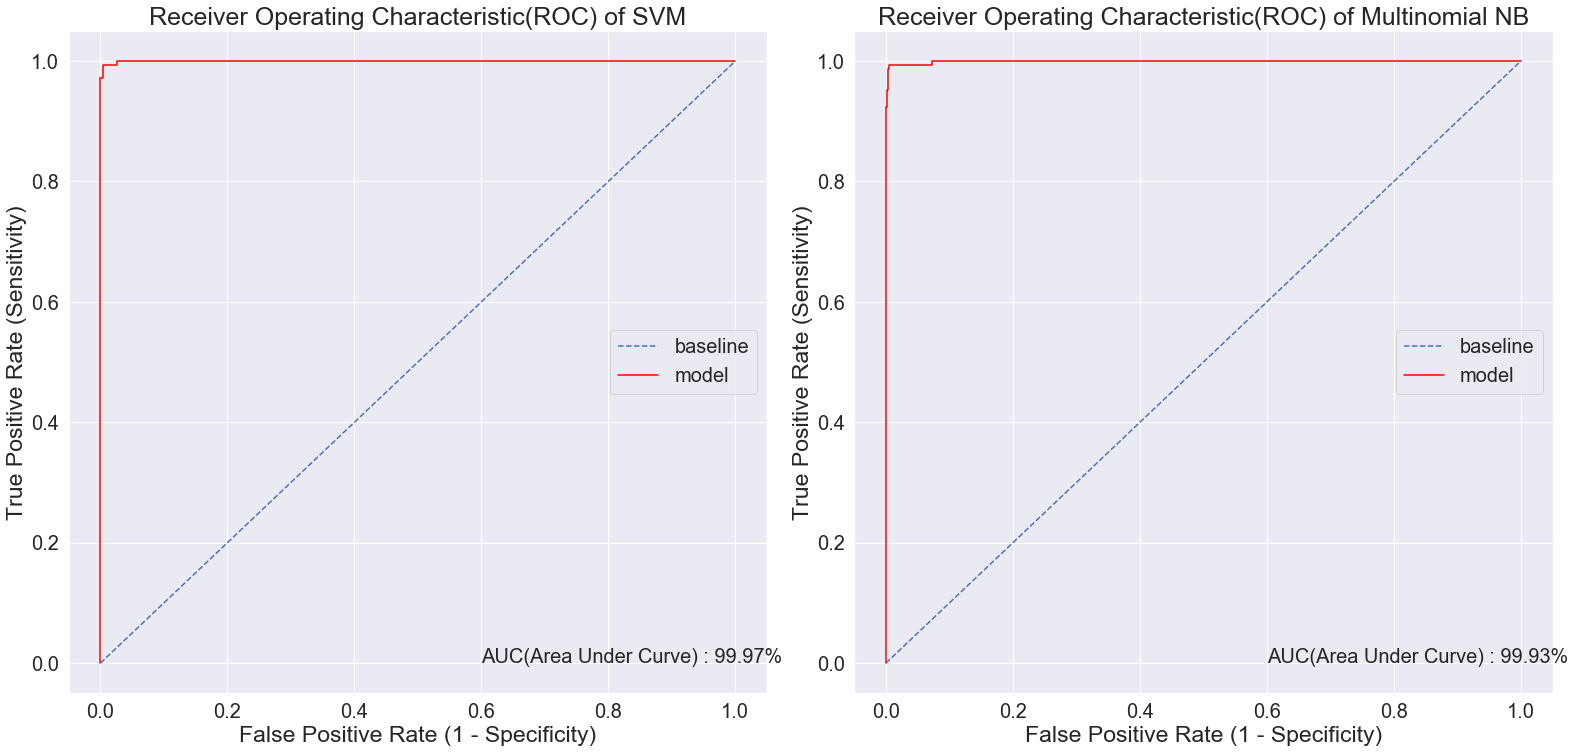

In [37]:
model_index = [0,1]
model = ['SVM','Multinomial NB']

best_threshold = []
for index ,model, model_name in zip(model_index,tuned_models,model):
    plt.subplot(2,2, index + 1 )
    
    y_prob = model.predict_proba(x_test)[:,1]
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    # plotting the roc curve for  the model
    plt.plot([0,1], [0,1], linestyle='--', label='baseline')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red',label = 'model')
    plt.text(0.6,0,'AUC(Area Under Curve) : '+str(round(roc_auc_score(y_test,y_prob)*100,2))+'%',fontsize = 20)
    plt.title('Receiver Operating Characteristic(ROC) of ' + model_name, fontsize = 25)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 23)
    plt.xlabel('False Positive Rate (1 - Specificity)',fontsize = 23)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(loc = 'center right', fontsize = 20)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(22, 20)
    plt.tight_layout()
plt.show()

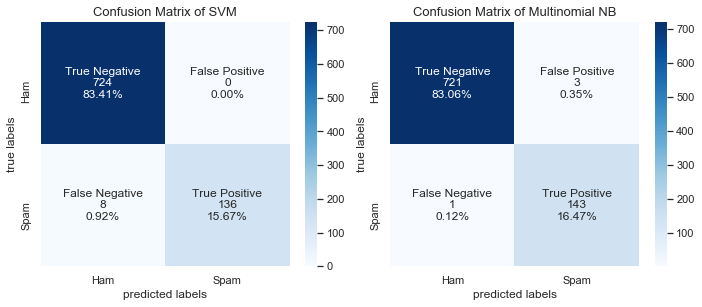

In [38]:
# visualizing confusion matrix with the help of heatmaps.
model_index = [0,1]
model = ['SVM','Multinomial NB']

for index ,model, model_name in zip(model_index,tuned_models,model):
    plt.subplot(2,2, index + 1 )
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)
    groups = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groups,group_counts,group_percent)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['Ham','Spam'])
    ax.set_yticklabels(['Ham','Spam'])
    fig.set_size_inches(10, 8)
    plt.tight_layout()
plt.show()